Everything on CPU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization, ELU, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(tf.__version__)

2.14.0


In [3]:
tf.random.set_seed(2024)

In [4]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')

stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

index = pd.read_pickle('data/SX5E_index.pkl')

In [5]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [6]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [7]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [8]:
train_price.shape, test_price.shape

((1016, 41), (269, 41))

In [9]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [10]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print('(Samples, time steps, features)')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(Samples, time steps, features)
(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


In [11]:
pd.DataFrame(scaled_train).head(16)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.541517,0.461622,0.034626,0.257120,0.013959,0.100755,0.169548,0.251664,0.429280,0.069447,...,0.016829,0.490880,0.029139,0.324387,0.173636,0.852899,0.899366,0.831756,0.049210,0.067080
1,0.529201,0.461799,0.034262,0.278435,0.003311,0.105064,0.177072,0.242479,0.415421,0.069170,...,0.007411,0.499854,0.019105,0.311892,0.180203,0.844386,0.895234,0.851984,0.042860,0.071488
2,0.516797,0.457860,0.036727,0.296042,0.000000,0.111241,0.184239,0.232479,0.412488,0.061482,...,0.006851,0.517925,0.012021,0.303981,0.189000,0.850401,0.895617,0.872443,0.035237,0.076776
3,0.507911,0.447295,0.034189,0.308523,0.004506,0.120639,0.181054,0.216559,0.409791,0.051458,...,0.000000,0.539547,0.008036,0.297443,0.197833,0.857331,0.891148,0.892111,0.023188,0.088735
4,0.508034,0.438925,0.037815,0.311910,0.032780,0.131367,0.187847,0.208864,0.419323,0.052887,...,0.000213,0.566854,0.008782,0.300046,0.204064,0.877588,0.891316,0.905895,0.018373,0.097186
5,0.511512,0.422013,0.041265,0.309480,0.062710,0.139578,0.178564,0.201452,0.420097,0.056054,...,0.002047,0.569700,0.009469,0.304128,0.211047,0.882571,0.890789,0.912355,0.015429,0.100457
6,0.521391,0.414747,0.040609,0.312093,0.061864,0.144239,0.165171,0.203834,0.430032,0.054294,...,0.004082,0.569046,0.004827,0.296455,0.212109,0.888026,0.879558,0.912538,0.022499,0.095597
7,0.522908,0.406736,0.044093,0.281079,0.061828,0.142693,0.157912,0.216265,0.429174,0.051623,...,0.013135,0.573871,0.000000,0.272436,0.210314,0.894143,0.863180,0.907484,0.033346,0.091237
8,0.526643,0.404740,0.043780,0.278568,0.063943,0.142578,0.153651,0.230493,0.420234,0.050776,...,0.027586,0.576559,0.002892,0.238750,0.206102,0.893838,0.852046,0.902328,0.037035,0.091054
9,0.530767,0.401711,0.042236,0.284384,0.087248,0.146637,0.145950,0.244864,0.413457,0.048868,...,0.039572,0.581729,0.024220,0.222509,0.197721,0.892704,0.842585,0.900060,0.044900,0.087584


In [12]:
y_train[0]

array([[0.57375545, 0.39893146, 0.06437328, 0.34211954, 0.18468364,
        0.14757604, 0.15820193, 0.23146491, 0.39263385, 0.04239953,
        0.14298896, 0.35850345, 0.01814811, 0.11799181, 0.4457627 ,
        0.13601568, 0.4683892 , 0.22343829, 0.11143575, 0.07930505,
        0.08803631, 0.12720957, 0.69378078, 0.10246328, 0.18349875,
        0.16302742, 0.0300701 , 0.14386724, 0.36465103, 0.18063451,
        0.21958413, 0.08440268, 0.57910612, 0.09897563, 0.25675073,
        0.17241916, 0.89049421, 0.77154303, 0.88986581, 0.06280436,
        0.07818394]])

In [13]:
X_train[0]

array([[5.41517497e-01, 4.61622419e-01, 3.46256104e-02, 2.57119733e-01,
        1.39587005e-02, 1.00754654e-01, 1.69547805e-01, 2.51663737e-01,
        4.29279557e-01, 6.94473107e-02, 2.34611053e-01, 3.70297457e-01,
        6.63307122e-02, 1.01872065e-01, 3.91173342e-01, 1.35496571e-01,
        4.08123162e-01, 2.37500855e-01, 1.63170999e-01, 1.17300197e-01,
        7.13347407e-02, 5.41255155e-02, 6.56006825e-01, 6.92384440e-02,
        1.95977993e-01, 1.17170024e-01, 8.86390227e-02, 1.56268167e-01,
        2.09577475e-01, 1.72731754e-01, 3.18454540e-01, 1.68289004e-02,
        4.90879943e-01, 2.91390213e-02, 3.24387023e-01, 1.73635728e-01,
        8.52898807e-01, 8.99365736e-01, 8.31755515e-01, 4.92100648e-02,
        6.70798906e-02],
       [5.29200994e-01, 4.61798844e-01, 3.42617711e-02, 2.78435479e-01,
        3.31113585e-03, 1.05064495e-01, 1.77071786e-01, 2.42479285e-01,
        4.15420725e-01, 6.91696514e-02, 2.15920869e-01, 3.64839847e-01,
        6.54307025e-02, 9.24787579e-02,

In [14]:
X_train.shape

(1001, 15, 41)

Everything matches. Each row of my dataset is an element of the arrays: 1001 samples where each sample has 15 timesteps for each of the 41 stocks. The sequences are ready for training.

### Functions

In [15]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

# aggregated metrics
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())


# metrics for each stock
def calculate_metrics(y_test_inverse, yhat_inverse, tukey):
    metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()

    for stock in range(y_test_inverse.shape[1]):
        stock_name = tukey.iloc[:, stock].name
        mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

        metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)
    
    return metrics_df


def plot_preds(yhat, ytest, metrics_df, model_name):
    # convert to df for nice plotting
    if isinstance(yhat, np.ndarray):
        predictions = pd.DataFrame(yhat, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
    if isinstance(ytest, np.ndarray):
        y_test_inverse_df = pd.DataFrame(ytest, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

    rand = np.random.choice(np.arange(41), size=10, replace=False)      # 10 stock random sample without replacement
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    for i, stock in enumerate(rand):
        row = i // 5
        col = i % 5
        axs[row, col].plot(predictions.iloc[:, stock], color='blue',
                           label='Predicted')
        axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
        axs[row, col].set_title(predictions.iloc[:, stock].name)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # metrics in top left
        axs[row, col].annotate(f"MAE: {metrics_df.loc[stock, 'MAE']:.2f}\nMSE: {metrics_df.loc[stock, 'MSE']:.2f}\nMAPE: {metrics_df.loc[stock, 'MAPE']:.2f}", 
                               xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    plt.suptitle(f"{model_name}: predicted vs realized", fontsize=16)
    
    # bottom legend
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.show()

## Sequence-2-Sequence Modeling (many-to-many) with LSTMs:
Using encoder-decoder architectures to forecast multiple time series with one model. The encoder is basically responsible for reading and interpreting the input. The encoder part compresses the input into a small representation (a fixed-length vector) of the original input, and this "context vector" is given to the decoder part as input to be interpreted and perform forecasting.
- RepeatVector layer is used to repeat N times the context vector we obtain from the encoder part. N is the number of future steps you want to forecast and is fed into the decoder part.
- A fully connected Dense layer is applied to each time step via TimeDistributed wrapper, so separates the output for each time step. The TimeDistributed allows to treat independently each time series.

### LSTM

In [16]:
model_enc_dec = Sequential(name='LSTM')
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

In [17]:
plot_model(model=model_enc_dec, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 4s 18ms/step - loss: 0.1534
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0276
Epoch 3/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0145
Epoch 4/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0103
Epoch 5/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0076
Epoch 6/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0059
Epoch 7/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0048
Epoch 8/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0042
Epoch 9/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0037
Epoch 10/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0034
Epoch 11/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0031
Epoch 12/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 13/50
32/32 [=============================

In [19]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [20]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [21]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

In [22]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 6.6353564
mse: 178.82236
mape: 10.482127


In [23]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=model_enc_dec.name)

NameError: name 'metrics_df' is not defined

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [24]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [44]:
initial_inv = 1000

test_index_series = index.loc['2017-01-02':]
test_index_series = ((test_index_series / test_index_series.iloc[0]) * initial_inv)
test_index_series = pd.Series(test_index_series['Close'], index = test_index_series.index)

portfolios_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=initial_inv)

tot_performance_LSTM['Index performance'] = ((test_index_series[-1] - test_index_series[0]) / test_index_series[0]) * 100
tot_performance_LSTM

{'Top5 performance': 24.627767978192878,
 'Top7 performance': 18.00103471910354,
 'Top10 performance': 13.822753060661375,
 'Index performance': 7.519056769262942}

In [45]:
plot_portfolios(portfolio_series_LSTM, index_perf = test_index_series)

### CNN encoder - LSTM decoder

In [230]:
cnn_lstm = Sequential(name='CNN-LSTM')
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))
cnn_lstm.compile(loss='mse', optimizer='adam')

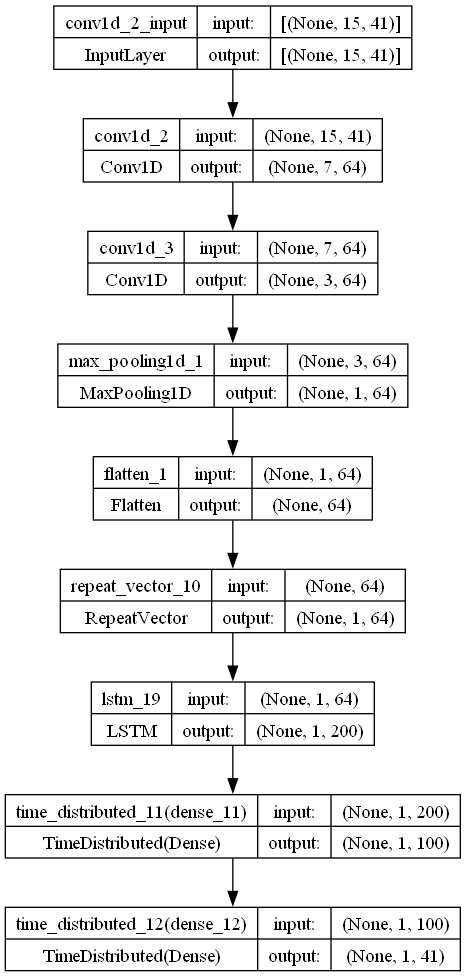

In [231]:
plot_model(model=cnn_lstm, show_shapes=True)

In [232]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 2s 5ms/step - loss: 0.1060
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0285
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0149
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 6/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 7/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0075
Epoch 8/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0066
Epoch 9/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 10/50
32/32 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 11/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 12/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 13/50
32/32 [==============================

In [233]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [234]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [235]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.4409323
mse: 61.80953
mape: 7.394274


In [236]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

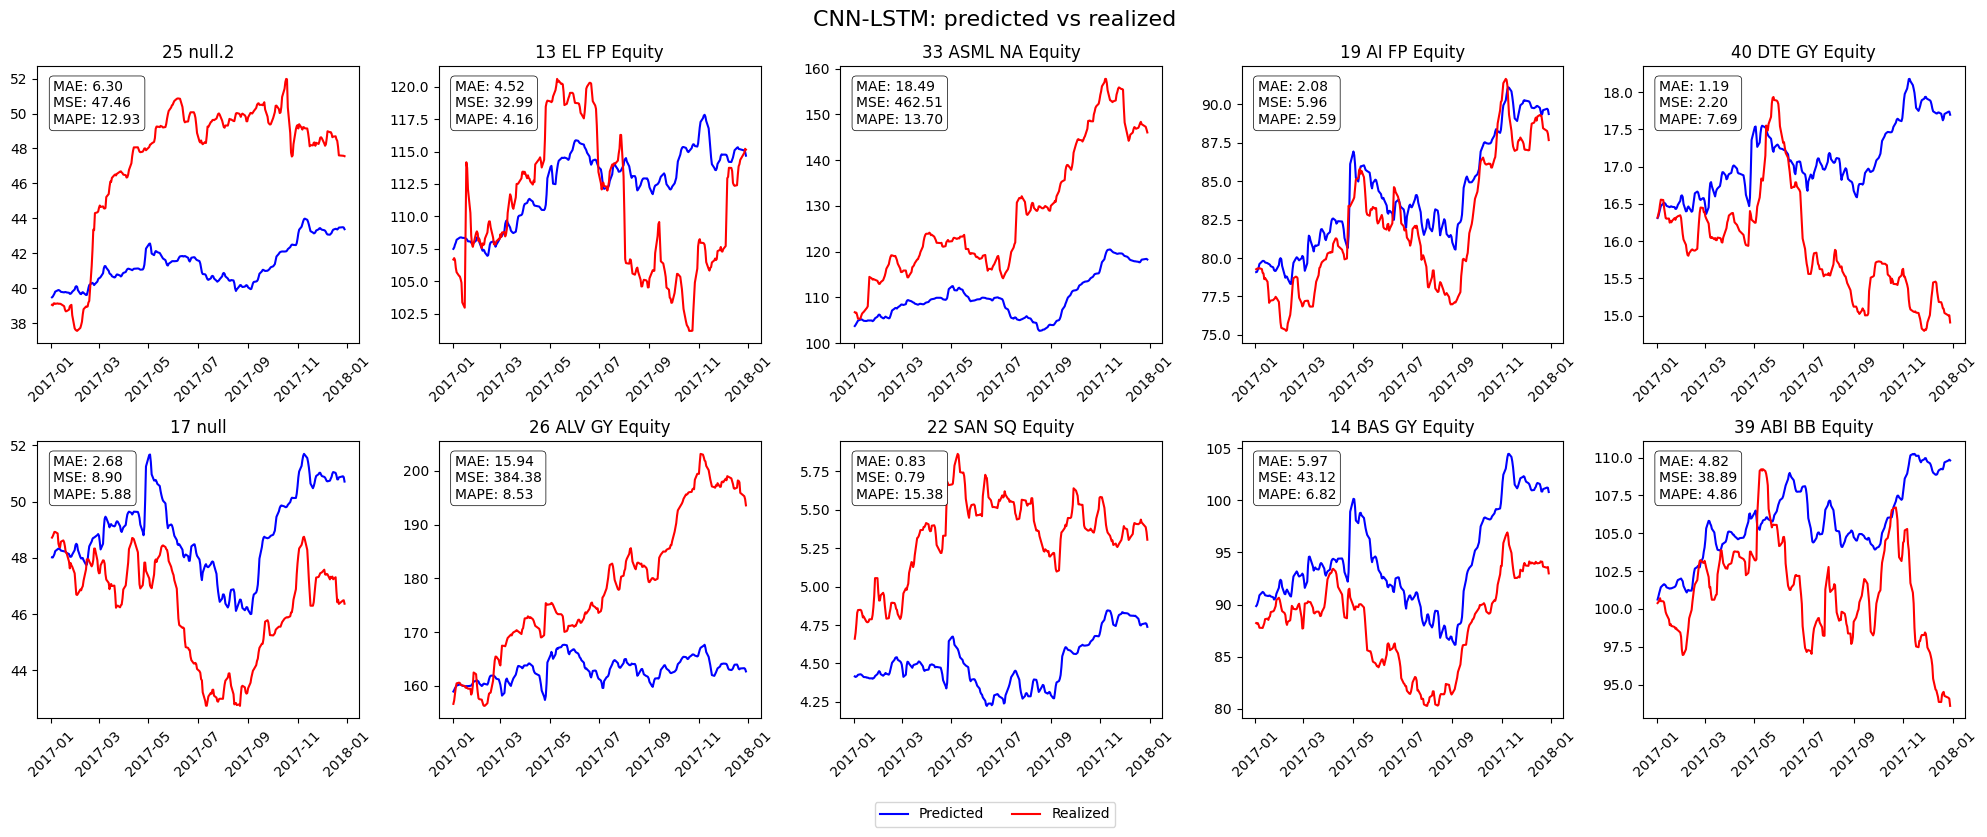

In [237]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=cnn_lstm.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [238]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [239]:
portfolios_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=100)

tot_performance_LSTM['Index performance'] = ((1 + index_returns.loc[yhat_inverse_df.index[0]:]).prod() - 1) * 100
tot_performance_LSTM

{'Top5 performance': 19.485579425833805,
 'Top7 performance': 16.999997769328417,
 'Top10 performance': 15.568458233449078,
 'Index performance': 8.73696808872011}

In [240]:
plot_portfolios(portfolio_series_LSTM, index_ret=index_returns)

### Multi-Head CNN-LSTM

The multi-head structure uses multiple one-dimensional CNN layers in order to process each time series and extract independent convolved features from each time series. These separate CNNs are called “head” and flattened, concatenated, and reshaped respectively before feeding into the LSTM layer. Therefore, they might be more successful to keep significant features of each time series and make better forecasts in this sense.

In [259]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts :)
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=5, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense, name='Multi-Head-CNN-LSTM')

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

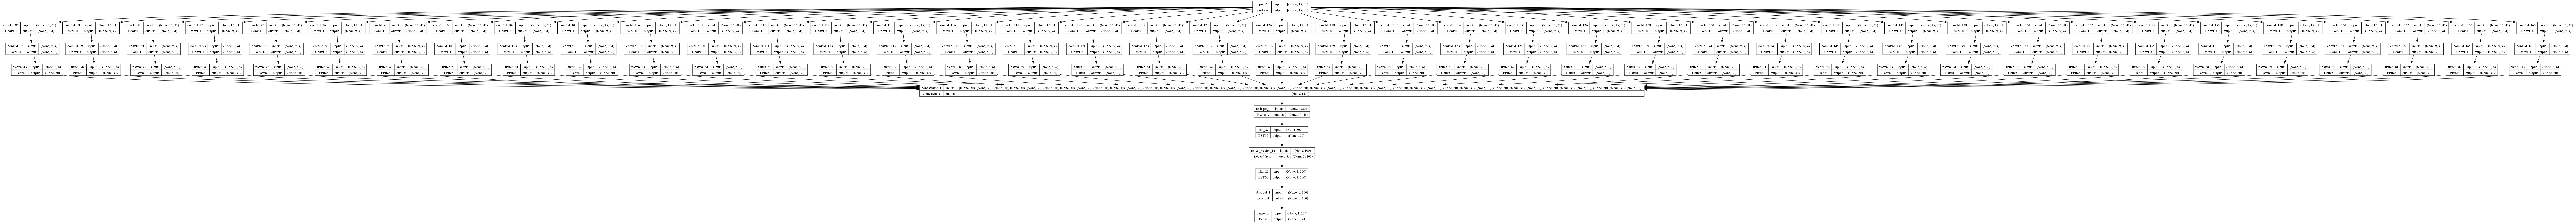

In [245]:
plot_model(model=multi_head_cnn_lstm_model, show_shapes=True)

In [261]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=70, batch_size=32)
# 70 epochs to reach global minimum

Epoch 1/70
32/32 [==============================] - 20s 23ms/step - loss: 0.1483
Epoch 2/70
32/32 [==============================] - 1s 25ms/step - loss: 0.0528
Epoch 3/70
32/32 [==============================] - 1s 23ms/step - loss: 0.0345
Epoch 4/70
32/32 [==============================] - 1s 24ms/step - loss: 0.0271
Epoch 5/70
32/32 [==============================] - 1s 22ms/step - loss: 0.0245
Epoch 6/70
32/32 [==============================] - 1s 24ms/step - loss: 0.0215
Epoch 7/70
32/32 [==============================] - 1s 24ms/step - loss: 0.0199
Epoch 8/70
32/32 [==============================] - 1s 24ms/step - loss: 0.0184
Epoch 9/70
32/32 [==============================] - 1s 25ms/step - loss: 0.0166
Epoch 10/70
32/32 [==============================] - 1s 23ms/step - loss: 0.0159
Epoch 11/70
32/32 [==============================] - 1s 27ms/step - loss: 0.0149
Epoch 12/70
32/32 [==============================] - 1s 24ms/step - loss: 0.0140
Epoch 13/70
32/32 [=================

In [262]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [263]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [264]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 5.0778427
mse: 93.28873
mape: 7.725726


In [265]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

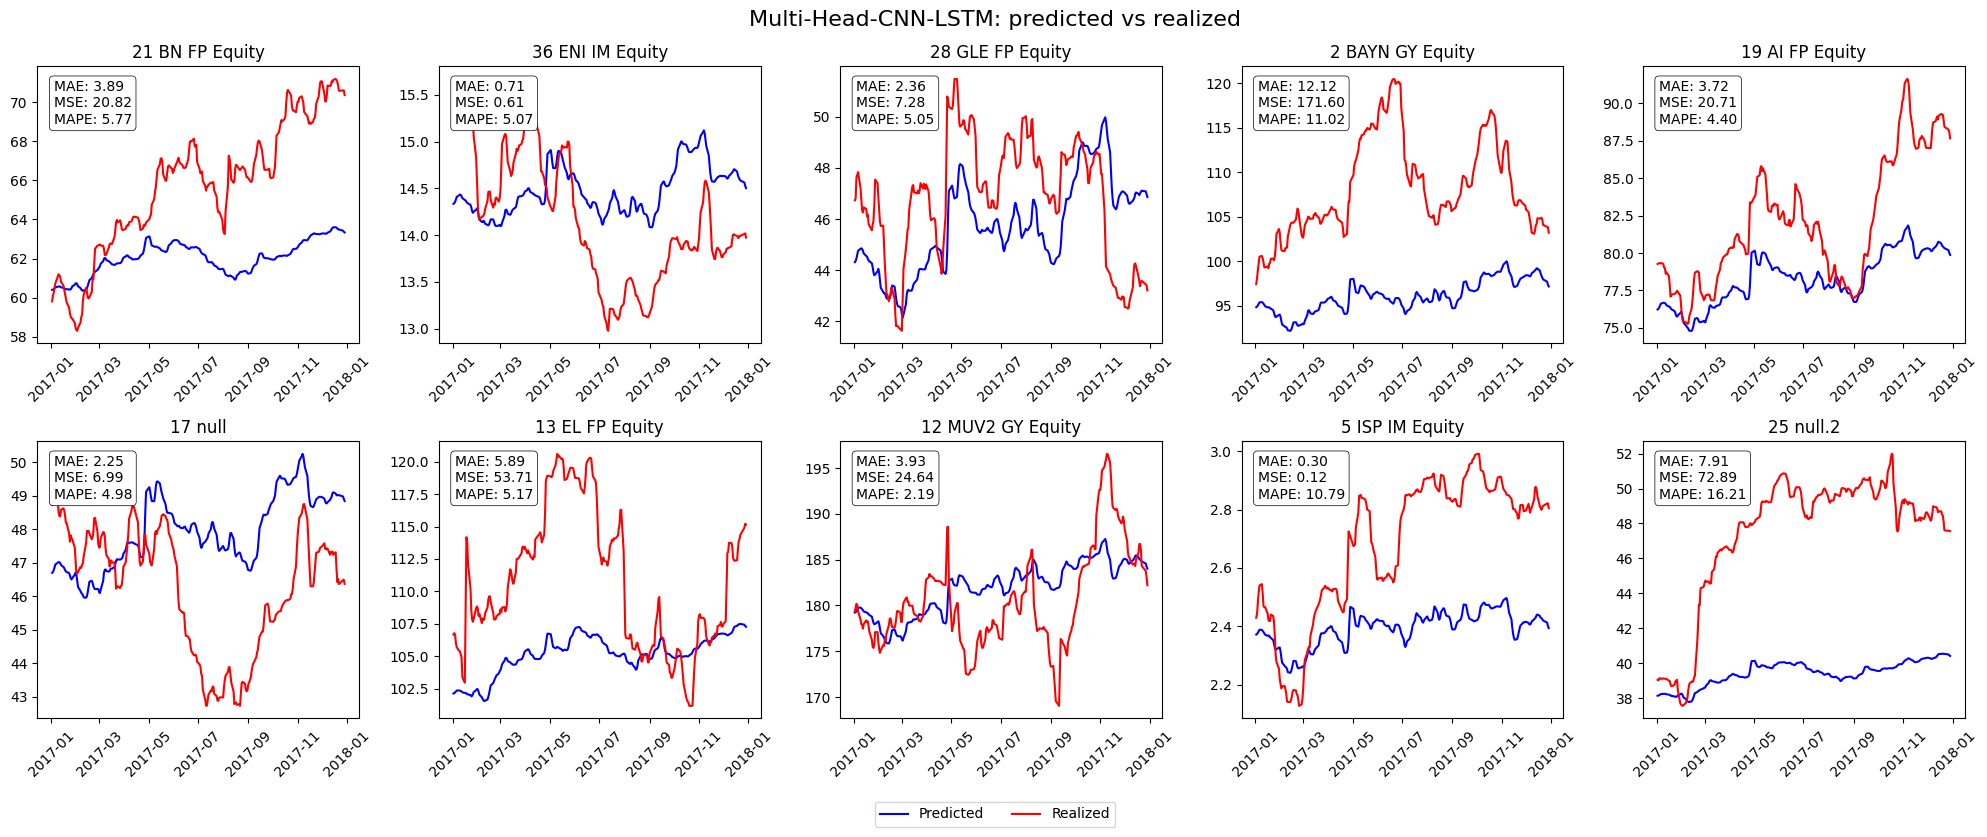

In [266]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=multi_head_cnn_lstm_model.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [267]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [268]:
portfolios_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=100)

tot_performance_LSTM['Index performance'] = ((1 + index_returns.loc[yhat_inverse_df.index[0]:]).prod() - 1) * 100
tot_performance_LSTM

{'Top5 performance': 21.707632654949606,
 'Top7 performance': 14.21106292374374,
 'Top10 performance': 12.558670673677966,
 'Index performance': 8.73696808872011}

In [269]:
plot_portfolios(portfolio_series_LSTM, index_ret=index_returns)

### CNN-BiLSTM

In [ ]:
plot_model(model=cnn_bilstm, show_shapes=True)

In [ ]:
history = cnn_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
yhat = cnn_bilstm.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

In [ ]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

In [ ]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=cnn_bilstm.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [ ]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
portfolios_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=100)

tot_performance_LSTM['Index performance'] = ((1 + index_returns.loc[yhat_inverse_df.index[0]:]).prod() - 1) * 100
tot_performance_LSTM

In [ ]:
plot_portfolios(portfolio_series_LSTM, index_ret=index_returns)

#### Could save the model(s) and/or the predictions of the model(s) in a pickle file and load them on an ptf_optimization.ipynb notebook